In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import seaborn as sns
from scipy import ndimage

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [8]:
SOURCE_IMG_SIZE = 48
IMG_SIZE = 96

CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry'] # , 'disgusted', 'afraid'
NUM_CLASSES = len(CLASSES)

## Pre-processing

In [9]:
df_fer = pd.read_csv('../data/fer2013.csv').iloc[:, 1:]
df_ferplus = pd.read_csv('../data/ferplus2013.csv').iloc[:, [2, 3, 4, 5, 6]]
df = df_fer.join(df_ferplus)
# df.head(15)

df['emotion'] = df.iloc[:, 2:].idxmax(axis=1).tolist()
df = df.replace(dict(zip(pd.Series(CLASSES),pd.Series(CLASSES).index)))
# df.head(15)

print('number of images:', df.shape[0])
df = df[(df.iloc[:, 2:-1].max(axis=1) > 5)]
print('after removing images with unknown/unsure classification:', df.shape[0])
# df.head(15)

df = df.iloc[:, [0, 1, -1]]
# df.head(15)

number of images: 35887
after removing images with unknown/unsure classification: 27307


In [110]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

images_np = np.array(df['pixels'])
label_np = np.array(df['emotion'])

images = []
images_raw = []
labels = []

for i in range(df.shape[0]):
    b = bytes(int(p) for p in images_np[i].split())
    img = Image.frombuffer('L', (SOURCE_IMG_SIZE, SOURCE_IMG_SIZE), b)
    images.append(transform(img))
    images_raw.append(img)
    labels.append(label_np[i])

## Filtering

In [111]:
kirsch_compass_masks = [
    np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]]),   # north
    np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]]),   # north-east
    np.array([[-3,-3,-3],[-3,0,-3],[5,5,5]]),   # east
    np.array([[-3,-3,-3],[5,0,-3],[5,5,-3]]),   # south-east
    # np.array([[5,-3,-3],[5,0,-3],[5,-3,-3]]),   # south
    # np.array([[5,5,-3],[5,0,-3],[-3,-3,-3]]),   # south-west 
    # np.array([[5,5,5],[-3,0,-3],[-3,-3,-3]]),   # west
    # np.array([[-3,5,5],[-3,0,5],[-3,-3,-3]]),   # north-west
]

In [113]:
images_filtered = []

transform = transforms.Compose([
    transforms.ToTensor()
])

for i in range(len(images)):
    img = images[i].squeeze(0)

    filtered = np.zeros_like(img)
    for cm in kirsch_compass_masks:
        k = ndimage.convolve(img, cm, mode='nearest', cval=0.0)
        filtered = np.add(filtered, k)

    filtered = transform(filtered)
    images_filtered.append(filtered)

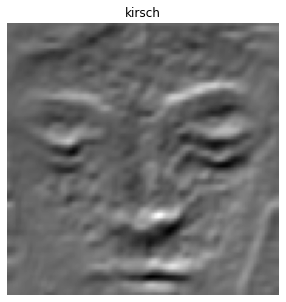

In [114]:
img = images_filtered[random.randint(0, len(images_filtered)-1)]

plt.figure(figsize=(5,5))
plt.title('kirsch')
plt.axis('off')
plt.imshow(img.permute(1,2,0), cmap='gray')

In [115]:
label_counts = [0]*NUM_CLASSES

for i in range(len(labels)):
    label_counts[labels[i]] += 1

print('\033[4m{: <15} {: >10}\033[0m'.format('class', '#images'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >10}'.format(CLASSES[i], label_counts[i]))

class              #images
neutral               9494
happy                 8802
surprised             3461
sad                   2958
angry                 2096
disgusted               66
afraid                 430


In [127]:
train_split_pct = 0.8
train_len = int(len(labels) * train_split_pct)

train_images = images_filtered[:train_len]
train_labels = labels[:train_len]
test_images = images_filtered[train_len:]
test_labels = labels[train_len:]

print(f'train length: {len(train_labels)} ({len(train_labels)*100/len(labels):.1f}%)')
print(f'test length: {len(test_labels)} ({len(test_labels)*100/len(labels):.1f}%)')

train length: 21845 (80.0%)
test length: 5462 (20.0%)


In [129]:
BATCH_SIZE = 64


class CustomDataset(Dataset):
    
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)


def get_loader(dataset):
    print('get_loader():')

    label_counts = [0]*NUM_CLASSES
    for i in range(len(dataset.labels)):
        label_counts[dataset.labels[i]] += 1

    class_weights = pow(np.array(label_counts) / sum(label_counts), -1)
    print('  class weights:', class_weights.round(3), '\n')

    sample_weights = [0]*len(dataset)
    for idx, (image, label) in enumerate(dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(dataset, BATCH_SIZE, sampler=sampler, shuffle=False)


train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

get_loader():
  class weights: [  2.899   3.07    7.906   9.129  13.231 474.891  63.874] 

get_loader():
  class weights: [  2.788   3.238   7.825   9.667  12.274 273.1    62.068] 



-----
# ConvNeXt Model

##### End of ConvNeXt model
-----

In [130]:
samples_train = [0]*NUM_CLASSES
samples_test = [0]*NUM_CLASSES

for idx, (images_filtered, labels) in enumerate(train_loader):
    for i in range(len(images_filtered)):
        samples_train[labels[i].item()] += 1

for idx, (images_filtered, labels) in enumerate(test_loader):
    for i in range(len(images_filtered)):
        samples_test[labels[i].item()] += 1


print('\033[4m{: <15} {: >15} {: >20}\033[0m'.format('class', '#samples (train)', '#samples (test)'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >15} {: >20}'.format(CLASSES[i], samples_train[i], samples_test[i]))

class           #samples (train)      #samples (test)
neutral                    3103                  784
happy                      3042                  790
surprised                  3160                  806
sad                        3114                  752
angry                      3142                  778
disgusted                  3087                  810
afraid                     3197                  742


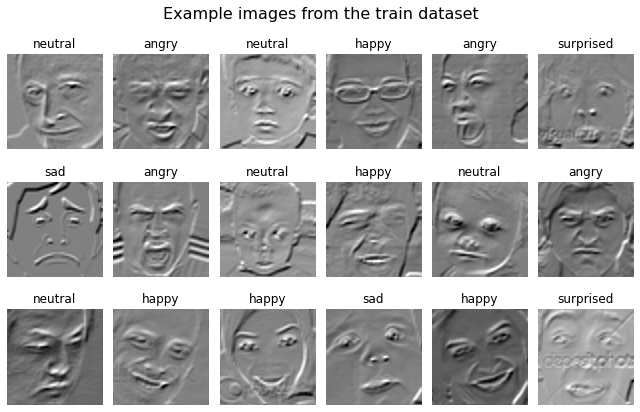

In [131]:
def imshow(dataset, title='', num_images=(3,6), rand=True):

    plt.figure(figsize=(num_images[1]*1.5, num_images[0]*2)); 
    plt.suptitle(title, fontsize=16)

    for i in range(num_images[0]):
        for j in range(num_images[1]):
            
            c = num_images[1]*i+(j+1)

            if not rand:
                idx = c
            else:
                idx = random.randint(0, len(dataset)-1)

            plt.subplot(num_images[0], num_images[1], c); plt.axis('off'); plt.title(CLASSES[dataset[idx][1]])
            plt.imshow(dataset[idx][0].permute(1,2,0), cmap='gray')

    plt.tight_layout(); plt.show()


imshow(train_dataset, 'Example images from the train dataset')